# Step 1: Upload the CSV File
First, upload your CSV file in Google Colab using files.upload(). This allows you to load the file into a DataFrame.

In [ ]:
import pandas as pd

## This imports the Pandas library, which is essential for data manipulation and analysis in Python.
## Here, `pd` is an alias that allows for shorthand references to Pandas functions.


from google.colab import files

## This line imports the `files` module from `google.colab`, which provides tools for handling
## file operations in Google Colab, such as uploading files.



# Upload the CSV file
uploaded = files.upload()

## This initiates a file upload dialog in Google Colab.
## When a user uploads a file, it is stored in the uploaded dictionary, where the
## keys are the file names and the values are the file contents in bytes.



# Load the uploaded file into a DataFrame
file_name = list(uploaded.keys())[0]  # Get the uploaded file name
data = pd.read_csv(file_name)

## The `file_name` line retrieves the file name of the uploaded file from the dictionary.
## Then, `pd.read_csv(file_name)` reads the CSV file into a Pandas DataFrame called `data`, which is a
## table-like data structure where each column represents a variable, and each row represents an observation.



print("Data Loaded Successfully")
data.head()

## `print("Data Loaded Successfully")` confirms that the file has been loaded without errors.
## `data.head()` displays the first few rows of the DataFrame, allowing you or any future user to check if the data has loaded correctly.


# Step 2: Data Preparation

Now, let's preprocess the data:
Convert the % column to numeric and scale it by 100. Also, Define categories for percentage ranges.

In [ ]:
# Calculate the average RLN_count for each Line_ID and Experiment, ignoring missing values
data = data.groupby(['Line_ID', 'Experiment'])['%'].mean().reset_index()

# Display the result
print(average_rln_count)


              Line_ID Experiment         %
0           AUS28451R         Y1  0.089363
1           AUS28451R         Y2  0.082444
2              Alpowa         Y1  1.000000
3              Alpowa         Y2  1.000000
4              RIL-10         Y1  0.586393
..                ...        ...       ...
297     UnplantedInoc         Y2  0.000000
298  UnplantedNonInoc         Y1  0.000000
299  UnplantedNonInoc         Y2  0.000000
300      VillaxStJose         Y1  0.291307
301      VillaxStJose         Y2  0.307764

[302 rows x 3 columns]


In [ ]:
# Check basic statistics of the % column to understand the distribution
print(data['%'].describe())

count    221.000000
mean      44.782061
std       27.457488
min        0.000000
25%       21.652268
50%       45.626350
75%       62.336431
max      196.746115
Name: %, dtype: float64


In [ ]:
# Step 2: Data Preparation
import numpy as np

# Convert the '%' column to numeric, treating non-numeric values (including empty cells) as NaN
data['%'] = pd.to_numeric(data['%'], errors='coerce') * 100

# Define percentage bins and labels
#bins = [0, 25, 50, 75, np.inf]
# Define bins based on actual data distribution (quartiles or custom ranges)
bins = [0, data['%'].quantile(0.125), data['%'].quantile(0.25), data['%'].quantile(0.375),
        data['%'].quantile(0.5), data['%'].quantile(0.625), data['%'].quantile(0.75), np.inf]
labels = ['<12.5%', '12.5-25%', '25-37.5%', '37.5-50%', '50-62.5%', '62.5-75%', '>75%']

# Create a new column categorizing the '%' values into these bins
data['Percentage_Category'] = pd.cut(data['%'], bins=bins, labels=labels, include_lowest=True)



In [ ]:
# Check the distribution of the categories
print(data['Percentage_Category'].value_counts())

Percentage_Category
>75%        55
<12.5%      28
12.5-25%    28
37.5-50%    28
62.5-75%    28
25-37.5%    27
50-62.5%    27
Name: count, dtype: int64


# Step 3: Set Up Interactive Widgets

Using `ipywidgets`, we can create controls for selecting experiments and customizing the chart title.

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Create dropdown widget for selecting experiment categories
experiment_options = data['Experiment'].unique().tolist()
experiment_select = widgets.SelectMultiple(
    options=experiment_options,
    value=experiment_options,  # Default to all experiments selected
    description='Experiments'
)

# Widget for customizing the chart title
title_widget = widgets.Text(value="", description="Chart Title:")


# Widgets for editing legend names
legend_label_1 = widgets.Text(value="Experiment-2", description="Legend for Y1:")
legend_label_2 = widgets.Text(value="Experiment-3", description="Legend for Y2:")

# Display the widgets
display(experiment_select, title_widget, legend_label_1, legend_label_2)



SelectMultiple(description='Experiments', index=(0, 1), options=('Y1', 'Y2'), value=('Y1', 'Y2'))

Text(value='', description='Chart Title:')

Text(value='Experiment-2', description='Legend for Y1:')

Text(value='Experiment-3', description='Legend for Y2:')

# Step 4: Define the Plotting Function

This function will generate a bar chart based on the selected experiments and update it dynamically.

In [ ]:
import matplotlib.pyplot as plt

# Function to generate and display the plot
def generate_plot(change=None):
    # Filter data based on selected experiments
    filtered_data = data[data['Experiment'].isin(experiment_select.value)]

    # Count the number of unique Line_IDs for each selected Experiment and Percentage_Category
    category_counts = filtered_data.groupby(['Experiment', 'Percentage_Category'])['Line_ID'].nunique().unstack(fill_value=0)

    # Plot the categorized data with the percentage categories on the x-axis
    fig, ax = plt.subplots(figsize=(8, 6))
    category_counts.T.plot(kind='bar', ax=ax)  # Transpose to get categories on x-axis

    # Customize the chart
    ax.set_xlabel('Percentage Category')
    ax.set_ylabel('Number of Lines')
    ax.set_title(title_widget.value)
    # Make x-axis labels parallel to the axis
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    # Use custom legend names from widgets
    plt.legend([legend_label_1.value, legend_label_2.value], title="", loc="upper right")
    plt.show()

# Link widgets to the plotting function to update plot on change
experiment_select.observe(generate_plot, names='value')
title_widget.observe(generate_plot, names='value')
legend_label_1.observe(generate_plot, names='value')
legend_label_2.observe(generate_plot, names='value')



# Step 5: Link Widgets to the Plotting Function

Set up the widgets to trigger generate_plot whenever their values change.

<ipython-input-127-56c0b0ce45a7>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_counts = filtered_data.groupby(['Experiment', 'Percentage_Category'])['Line_ID'].nunique().unstack(fill_value=0)


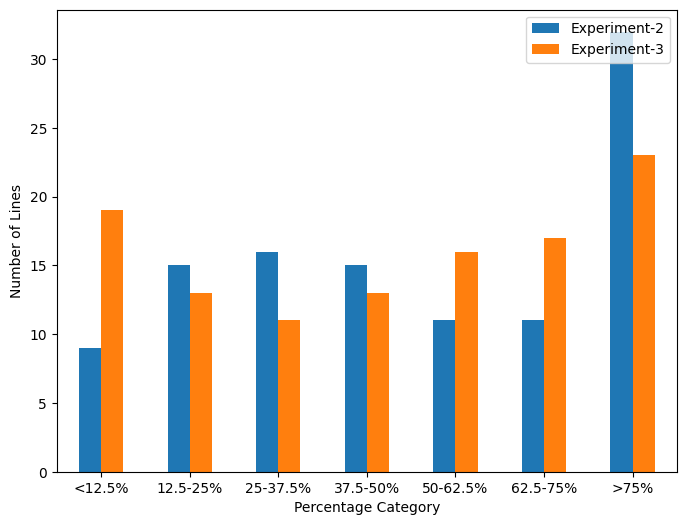

In [ ]:
# Set up the plot to update when the experiment selection or title changes
experiment_select.observe(generate_plot, names='value')
title_widget.observe(generate_plot, names='value')

# Generate the initial plot
generate_plot()
